# HRRR Data from the AWS cloud

#### Intent: Extract data from the most recently updated HRRR run to produce a 12-hour forecast for a latitude/longitude point. 

This notebook is an introduction to accessing HRRR data from the AWS Cloud. The first block of code, when run, produces a csv file populated with forecasted surface variables from the latest HRRR run, which cover an extent of 12 hours from the current time step. If desired, this code block can be run automatically, at a certain time or on computer start-up, with the assistance of other programs. The remaining blocks of code are meant to provide a rudimentary visualization of the variables forecasted for the next 12 hours. 

## Pre-Block: Install these packages 

In [1]:
!pip install numpy
!pip install Cartopy
!pip install pandas
!pip install matplotlib
!pip install xarray
!pip install requests
!pip install netCDF4
!pip install metpy
!pip install h5py
!pip install numcodecs
!pip install s3fs
!pip install google
!pip install google-cloud-storage
!pip install azure-storage-blob
!pip install zarr
!pip install pytz


## Block 1: Get the data from AWS, then populate a CSV file.
now with added UTC to MTN time conversion

In [2]:
import s3fs
import numpy as np
from datetime import datetime, timedelta, date
import numcodecs as ncd
import metpy
import metpy.units as mu
import metpy.calc as mc
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
from pytz import timezone  # New import for timezone conversion

def get_nearest_point(projection, chunk_index, longitude, latitude):
    x, y = projection.transform_point(longitude, latitude, ccrs.PlateCarree())
    return chunk_index.sel(x=x, y=y, method="nearest")

def retrieve_data(s3_url):
    with fs.open(s3_url, 'rb') as compressed_data:
        buffer = ncd.blosc.decompress(compressed_data.read())

        dtype = "<f2"
        if "surface/PRES" in s3_url:
            dtype = "<f4"
        
        chunk = np.frombuffer(buffer, dtype=dtype)
        
        entry_size = 150*150
        num_entries = len(chunk)//entry_size
        
        if num_entries == 1:
            data_array = np.reshape(chunk, (150, 150))
        else:
            data_array = np.reshape(chunk, (num_entries, 150, 150))
    
    return data_array

# Lists
forecast_hour = []
date_list = []
temp_list = []
pres_list = []
snow_list = []
gust_list = []
accum_snow = []
rh_list = []
ugrd_list = []
vgrd_list = []
wind_list = []
carinal_wind_dir = []

surface_list = ["SNOD", "GUST", "ASNOW_acc_fcst", "PRES","TMP"]
twom_list = ["RH"]
tenm_list = ["UGRD", "VGRD", "WIND_1hr_max_fcst"]

# Location
point_lat = 39.58148838130895
point_lon = -105.94259648925797

# Find chunk that contains coordinates
fs = s3fs.S3FileSystem(anon=True)

chunk_index = xr.open_zarr(s3fs.S3Map("s3://hrrrzarr/grid/HRRR_chunk_index.zarr", s3=fs))
projection = ccrs.LambertConformal(central_longitude=262.5, 
                                   central_latitude=38.5, 
                                   standard_parallels=(38.5, 38.5),
                                    globe=ccrs.Globe(semimajor_axis=6371229,
                                                     semiminor_axis=6371229))
nearest_point = get_nearest_point(projection, chunk_index, point_lon, point_lat)
fcst_chunk_id = f"0.{nearest_point.chunk_id.values}"

# Date range:
now = datetime.now() - timedelta(hours=3)
day = now.strftime("%Y%m%d")
hr = now.strftime("%H")

for var in surface_list:
    level = 'surface'
    data_url = f'hrrrzarr/sfc/{day}/{day}_{hr}z_fcst.zarr/{level}/{var}/{level}/{var}/'
    
    data = retrieve_data(data_url + fcst_chunk_id)
    gridpoint_forecast = data[:, nearest_point.in_chunk_y, nearest_point.in_chunk_x]
    
    for n in range(3, 15):
        if var == "PRES":
            pres_list.append(gridpoint_forecast[n])
            date_list.append(day)
            forecast_hour.append(n + int(hr))
        if var == "TMP":
            temp_list.append(gridpoint_forecast[n])
        elif var == "SNOD":
            snow_list.append(gridpoint_forecast[n])
        elif var == "GUST":
            gust_list.append(gridpoint_forecast[n])
        elif var == "ASNOW_acc_fcst":
            accum_snow.append(gridpoint_forecast[n])

for var in twom_list:
    level = '2m_above_ground'
    data_url = f'hrrrzarr/sfc/{day}/{day}_{hr}z_fcst.zarr/{level}/{var}/{level}/{var}/'
    
    data = retrieve_data(data_url + fcst_chunk_id)
    gridpoint_forecast = data[:, nearest_point.in_chunk_y, nearest_point.in_chunk_x]
    
    for n in range(3, 15):
        if var == "RH":
            rh_list.append(gridpoint_forecast[n])

for var in tenm_list:
    level = '10m_above_ground'
    data_url = f'hrrrzarr/sfc/{day}/{day}_{hr}z_fcst.zarr/{level}/{var}/{level}/{var}/'
    
    data = retrieve_data(data_url + fcst_chunk_id)
    gridpoint_forecast = data[:, nearest_point.in_chunk_y, nearest_point.in_chunk_x]
    
    for n in range(3, 15):
        if var == "UGRD":
            ugrd_list.append(gridpoint_forecast[n])
        elif var == "VGRD":
            vgrd_list.append(gridpoint_forecast[n])
        elif var == "WIND_1hr_max_fcst":
            wind_list.append(gridpoint_forecast[n])

# Calc wind direction
for i in range(0, len(ugrd_list)):
    direction = metpy.calc.wind_direction(ugrd_list[i]*mu.units.metre/mu.units.second, vgrd_list[i]*mu.units.metre/mu.units.second)
    cardinal_direction = direction.magnitude
    carinal_wind_dir.append(mc.angle_to_direction(int(cardinal_direction)))

# Put output into a dataframe
output = pd.DataFrame({
    'Date': date_list,
    'Hour_UTC': forecast_hour,
    'Pres': pres_list,
    'Temp': temp_list,
    'Snow_Depth': snow_list,
    'Hourly_Snow': accum_snow,
    'RH': rh_list,
    'Gust': gust_list,
    'Wind_Dir': carinal_wind_dir,
    'Wind_Speed': wind_list,
})

# Convert 'Date' to datetime format
output['Date'] = pd.to_datetime(output['Date'], format='%Y%m%d')

# Correct hours that are 24 or more and adjust dates accordingly
for i in range(len(output)):
    if output.at[i, 'Hour_UTC'] >= 24:
        extra_days = int(output.at[i, 'Hour_UTC'] // 24)  # Convert to native Python int
        output.at[i, 'Date'] += timedelta(days=extra_days)
        output.at[i, 'Hour_UTC'] %= 24

# New timezone conversion code
denver_timezone = timezone('America/Denver')  # Define the timezone for Denver
output['Datetime_UTC'] = pd.to_datetime(output['Date'].astype(str) + ' ' + output['Hour_UTC'].astype(str).str.zfill(2))
output['Datetime_UTC'] = output['Datetime_UTC'].dt.tz_localize('UTC')  # Localize as UTC
output['Datetime_Local'] = output['Datetime_UTC'].dt.tz_convert(denver_timezone)  # Convert to Denver Time
output.drop(columns=['Date', 'Hour_UTC'], inplace=True)  # Drop original Date and Hour_UTC columns
output['Date_Local'] = output['Datetime_Local'].dt.strftime('%m/%d/%y')  # Extract local date
output['Hour_Local'] = output['Datetime_Local'].dt.hour  # Extract local hour

output.Pres = output.Pres / 3386  # inHg
output.Temp = (output.Temp - 273.15) * (9/5) + 32  # F
output.Snow_Depth = output.Snow_Depth * 39.37  # in
output.Hourly_Snow = output.Hourly_Snow * 39.37  # in
output.Gust = output.Gust * 2.24  # mph

# Define the desired order of columns
column_order = ['Date_Local', 'Hour_Local', 'Temp', 'Snow_Depth', 'Hourly_Snow', 'RH', 'Gust', 'Wind_Dir', 'Wind_Speed', 'Pres', 'Datetime_UTC']

# Reorder the columns in the DataFrame
output = output[column_order]

# original print format
#print(output)

# Put output into CSV file
output.to_csv('weather.csv', index=False)

# Convert the DataFrame to a CSV string and print
csv_string = output.to_csv(index=False)
print(csv_string)


Date_Local,Hour_Local,Temp,Snow_Depth,Hourly_Snow,RH,Gust,Wind_Dir,Wind_Speed,Pres,Datetime_UTC
11/15/23,15,42.8,0.0,0.0,16.4,9.31,WNW,4.543,20.23036,2023-11-15 22:00:00+00:00
11/15/23,16,30.2,0.0,0.0,17.8,7.367,W,2.521,20.236267,2023-11-15 23:00:00+00:00
11/15/23,17,25.25,0.0,0.0,20.1,6.633,WNW,2.09,20.245127,2023-11-16 00:00:00+00:00
11/15/23,18,18.5,0.0,0.0,19.5,2.781,NE,1.373,20.23922,2023-11-16 01:00:00+00:00
11/15/23,19,16.25,0.0,0.0,18.6,3.22,SE,1.203,20.2215,2023-11-16 02:00:00+00:00
11/15/23,20,14.0,0.0,0.0,18.4,2.338,ESE,1.263,20.209686,2023-11-16 03:00:00+00:00
11/15/23,21,12.2,0.0,0.0,19.0,6.15,ENE,0.9683,20.200827,2023-11-16 04:00:00+00:00
11/15/23,22,11.3,0.0,0.0,21.5,12.59,WSW,2.732,20.209686,2023-11-16 05:00:00+00:00
11/15/23,23,12.2,0.0,0.0,24.1,11.0,WSW,3.787,20.206734,2023-11-16 06:00:00+00:00
11/16/23,0,11.3,0.0,0.0,27.7,11.07,WSW,3.672,20.209686,2023-11-16 07:00:00+00:00
11/16/23,1,13.11,0.0,0.0,31.3,13.11,WSW,4.324,20.189014,2023-11-16 08:00:00+00:00
11/16/23,2,18

## Block 2: Visualize the 12-hour forecast. 

updated x-axis labels to local mtn time 

Current date/time: 2023-11-15 22:36:16.231139 UTC
HRRR data from: 19 UTC


Text(0.5, 0, 'Time (MTN)')

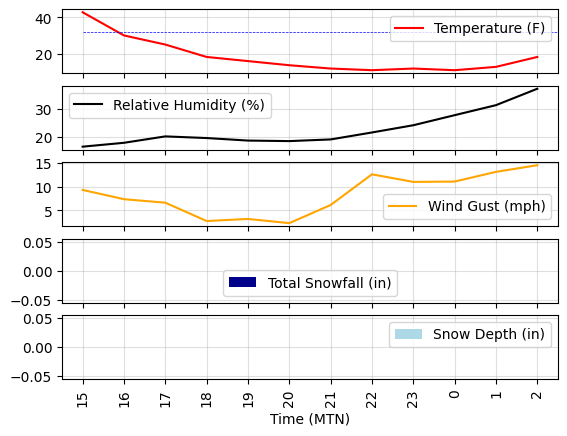

In [9]:
import matplotlib.pyplot as plt

print(f"Current date/time: {datetime.now()} UTC")
print(f"HRRR data from: {hr} UTC")

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex=True)
output.Temp.plot(ax=ax1, color = "red", label = "Temperature (F)")
output.RH.plot(ax=ax2, color = "black", label = "Relative Humidity (%)")
output.Gust.plot(ax=ax3, color = "orange", label = "Wind Gust (mph)")
output.Hourly_Snow.plot.bar(ax=ax4, color = "darkblue", label = "Total Snowfall (in)")
output.Snow_Depth.plot.bar(ax=ax5, color = "lightblue", label = "Snow Depth (in)")
ax1.legend()
ax1.grid(alpha=0.4)
ax1.hlines(y=32, xmin=0, xmax=12, linewidth=.5, linestyles='--', color='blue')
ax2.legend()
ax2.grid(alpha=0.4)
ax3.legend()
ax3.grid(alpha=0.4)
ax4.legend()
ax4.grid(alpha=0.4)
ax5.legend()
ax5.grid(alpha=0.4)
ax1.set_xticklabels(output.Hour_Local)
plt.xlabel("Time (MTN)")

https://mesowest.utah.edu/html/hrrr/zarr_documentation/html/ex_python_plot_zarr.html
https://github.com/ldicarlo1/weather_forecast_bias_correction/blob/main/Bias%20Correction%20of%20Weather%20Forecasts%20Using%20Machine%20Learning.pdf
https://mesowest.utah.edu/html/hrrr/zarr_documentation/html/zarr_variables.html     
https://registry.opendata.aws/noaa-hrrr-pds/